In [155]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import scale 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import matplotlib.colors as mcolors
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV

## Dataset "possum" 
Dataset descargado de https://www.kaggle.com/datasets/abrambeyer/openintro-possum, y cargado como dataframe de Pandas

In [156]:
possum = pd.read_csv("possum.csv")
possum.head()

,case,site,Pop,sex,age,hdlngth,skullw,totlngth,taill,footlgth,earconch,eye,chest,belly
0,1,1,Vic,m,8.0,94.1,60.4,89.0,36.0,74.5,54.5,15.2,28.0,36.0
1,2,1,Vic,f,6.0,92.5,57.6,91.5,36.5,72.5,51.2,16.0,28.5,33.0
2,3,1,Vic,f,6.0,94.0,60.0,95.5,39.0,75.4,51.9,15.5,30.0,34.0
3,4,1,Vic,f,6.0,93.2,57.1,92.0,38.0,76.1,52.2,15.2,28.0,34.0
4,5,1,Vic,f,2.0,91.5,56.3,85.5,36.0,71.0,53.2,15.1,28.5,33.0


# Pre-proceso del dataset

Eliminamos columnas que en principio no parecieran tener relación con la variable target

In [157]:
# Eliminamos columna 'case'
possum.drop(['case'], axis=1, inplace=True)

En las columnas donde se encontraron valores NaN, los reemplazamos por la media de los valores restantes de la columna en cuestión.

In [158]:
#Delete NaNs
possum = possum.fillna(possum.mean())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


Definimos un enconder para transformar las variables categóricas

In [159]:
#Encode Pop column
def encode(X,flip=False):
  values=np.unique(X)
  intermediate=np.array(X)
  if flip:
    values=values[::-1]
  iterator=list(enumerate(values))
  for i,value in iterator:
    currentPositions=np.where(X==value)  
    intermediate[currentPositions]=i/(len(values)-1)
  return intermediate,values

popEncoding,popEncoder=encode(possum["Pop"])
possum["Pop"]=popEncoding
print(popEncoding)
print(popEncoder)

[0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0]
['Vic' 'other']


Observamos la correlación del dataset original

In [160]:
corr = possum.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  


,site,age,hdlngth,skullw,totlngth,taill,footlgth,earconch,eye,chest,belly
site,1.00,-0.13,-0.16,-0.08,-0.26,0.38,-0.78,-0.79,-0.04,-0.35,-0.18
age,-0.13,1.00,0.31,0.28,0.25,0.12,0.13,0.05,0.23,0.33,0.35
hdlngth,-0.16,0.31,1.00,0.71,0.69,0.29,0.39,0.12,0.35,0.63,0.56
skullw,-0.08,0.28,0.71,1.00,0.53,0.26,0.28,-0.00,0.32,0.63,0.45
totlngth,-0.26,0.25,0.69,0.53,1.00,0.57,0.44,0.15,0.25,0.58,0.52
taill,0.38,0.12,0.29,0.26,0.57,1.00,-0.13,-0.39,0.20,0.17,0.29
footlgth,-0.78,0.13,0.39,0.28,0.44,-0.13,1.00,0.77,0.01,0.45,0.30
earconch,-0.79,0.05,0.12,-0.00,0.15,-0.39,0.77,1.00,-0.17,0.20,0.07
eye,-0.04,0.23,0.35,0.32,0.25,0.20,0.01,-0.17,1.00,0.15,0.24
chest,-0.35,0.33,0.63,0.63,0.58,0.17,0.45,0.20,0.15,1.00,0.61


Se aprecia la existencia de variables moderada a altamentente correlacionadas entre sí. 

Separamos dataset en conjuntos de train y test, y al mismo tiempo encodeamos la variable de salida

In [161]:
#Separar Dataset

X = possum.loc[:, possum.columns != 'sex']
y = possum.loc[:, possum.columns == 'sex']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_train=np.array(y_train)
y_train=y_train.reshape(-1)

y_train_encoded,y_train_encoder=encode(y_train)
y_train_encoded=y_train_encoded.astype('int')

y_test=np.array(y_test)
y_test=y_test.reshape(-1)
y_test_encoded,y_test_encoder=encode(y_test)
y_test_encoded=y_test_encoded.astype('int')

# Encodeamos en forma reversa la variable target y_test para realizar pruebas más adelante con el clasificador no supervisado K-means
y_test_encoded_reverse,y_test_encoder_reverse=encode(y_test,True)
y_test_encoded_reverse=y_test_encoded_reverse.astype('int')


Varios de los predictores del dataset original indican medidas de partes del cuerpo de las zarigüeyas que naturalmente tienden a incrementarse todas al mismo tiempo, como por ejemplo las medidas de largo total, del largo de la cola, del largo del pie, etcétera. En consecuencia, es esperable encontrar valores masyores a 0.6 en valor absoluto en la matriz de correlaciones previamente mostrada.

Por este motivo, transformamos el dataset original mediante PCA para eliminar dichas correlaciones y para reducir la cantidad de predictores que afectan a la variable de salida 'sex'.

In [162]:
# Hacemos PCA

# Estandarizamos los conjuntos de train y de test
X_train_scaled = scale(X_train)
X_test_scaled = scale(X_test)

qOfComponents=12
pcaArray=np.array([])
X_pca_Array=np.array([])
for i in range(1,qOfComponents+1):
  pca = PCA(i)
  pca.fit(X_train_scaled)
  pca.components_
  X_pca = pca.transform(X_train_scaled)
  X_pca_Array=np.append(X_pca_Array,X_pca)
  pcaArray=np.append(pcaArray,pca)
  print("Con",i,"componente/s, tenemos el",100*sum(pca.explained_variance_ratio_)," porciento de la varianza  ")


Con 1 componente/s, tenemos el 37.452185582508754  porciento de la varianza  
Con 2 componente/s, tenemos el 65.44944617690722  porciento de la varianza  
Con 3 componente/s, tenemos el 74.28964360863759  porciento de la varianza  
Con 4 componente/s, tenemos el 80.97202918190514  porciento de la varianza  
Con 5 componente/s, tenemos el 86.81279260213562  porciento de la varianza  
Con 6 componente/s, tenemos el 91.23008077114241  porciento de la varianza  
Con 7 componente/s, tenemos el 93.99283137485611  porciento de la varianza  
Con 8 componente/s, tenemos el 96.08104048664326  porciento de la varianza  
Con 9 componente/s, tenemos el 97.50443178281272  porciento de la varianza  
Con 10 componente/s, tenemos el 98.73637835553463  porciento de la varianza  
Con 11 componente/s, tenemos el 99.5871345850583  porciento de la varianza  
Con 12 componente/s, tenemos el 99.99999999999997  porciento de la varianza  


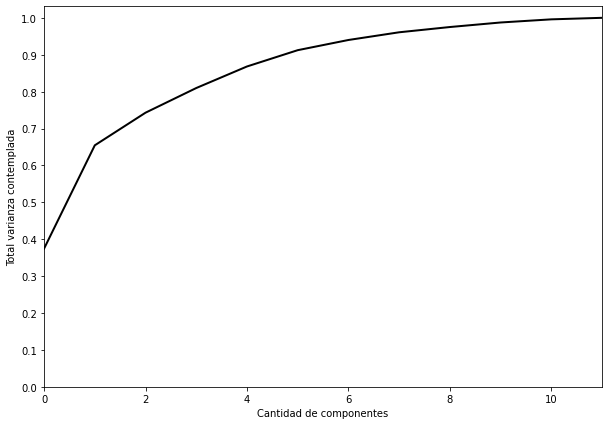

In [163]:
plt.figure(figsize=(10,7))
plt.plot(np.cumsum(pca.explained_variance_ratio_), color='k', lw=2)
plt.xlabel('Cantidad de componentes')
plt.ylabel('Total varianza contemplada')
plt.xlim(0, 11)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.show();

Tanto en el ítem de clasificación en m/f como en el de predicción de 'totlength' emplearemos Principal Component Regression (https://en.wikipedia.org/wiki/Principal_component_regression). Este concepto implica emplear como predictores las primeras $k$ componentes principales del dataset en lugar de los predictores originales. Una de las principales ventajas de esta técnica es eliminar el problema de la multi-colinealidad de los datos. A su vez, es considerado un tipo de estrategia de regularización.

Sin embargo, una de las principales desventajas de este método es la pérdida de la 'explicabilidad' del modelo.

# Clasificación en m/f
Los dos métodos de clasificación que se utilizarán para este fin son: i) regresión logística, y ii) K-Means.


### Regresión logística

In [164]:
#Regresion Logistica sin PCA, pero sobre los conjuntos de train y test escalados
clf = LogisticRegression(random_state=45,max_iter=250000).fit(X_train_scaled, y_train_encoded)
yhat = clf.predict(X_test_scaled)

print("MSE",sum((y_test_encoded-yhat)**2)/len(yhat))
print("Score",clf.score(X_test_scaled, y_test_encoded))

MSE 0.2857142857142857
Score 0.7142857142857143


In [165]:
#Regresion Logistica con PCA
#Como solo tenemos 2 clases a definir el MSE es igual a 1-score, por lo tanto solo mostramos el MSE
MSES=[]
for i in range(qOfComponents):
  pca=pcaArray[i]
  clf = LogisticRegression(random_state=45,max_iter=250000).fit(pca.transform(X_train_scaled), y_train_encoded)

  yhat=clf.predict(pca.transform(X_test_scaled))

  mse=sum((y_test_encoded-yhat)**2)/len(yhat)
  MSES.append(mse)
  print("MSE para",i+1,"componentes es",mse)
  #print("Score para",i,"componentes es",clf.score(pca.transform(X_test), y_test_encoded))
sort=np.argsort(MSES)
print("El error mínimo fue alcanzado utilizando",sort[0]+1,"componentes del dataset reducido con PCA, el cual fue de",min(MSES))

MSE para 1 componentes es 0.38095238095238093
MSE para 2 componentes es 0.3333333333333333
MSE para 3 componentes es 0.2857142857142857
MSE para 4 componentes es 0.42857142857142855
MSE para 5 componentes es 0.3333333333333333
MSE para 6 componentes es 0.3333333333333333
MSE para 7 componentes es 0.19047619047619047
MSE para 8 componentes es 0.3333333333333333
MSE para 9 componentes es 0.38095238095238093
MSE para 10 componentes es 0.3333333333333333
MSE para 11 componentes es 0.3333333333333333
MSE para 12 componentes es 0.2857142857142857
El error mínimo fue alcanzado utilizando 7 componentes del dataset reducido con PCA, el cual fue de 0.19047619047619047


### KMeans

In [166]:
#Hacemos K means con 2 clusters(masculino o femenido) usando nuestra dataset reducido con PCA de 1 a 10 componentes para ver si hay diferencia
print("Resultados K-Means")
kmeans = KMeans(n_clusters=2, random_state=0).fit(X_train_scaled)
yhat=kmeans.predict(X_test_scaled)
mse=sum((y_test_encoded-yhat)**2)/len(yhat)
mse_reverse=sum((y_test_encoded_reverse-yhat)**2)/len(yhat)
print("MSE para el dataset entero es es",min(mse,mse_reverse))
for i in range(qOfComponents):
  pca=pcaArray[i]
  kmeans = KMeans(n_clusters=2, random_state=0).fit(pca.transform(X_train_scaled))
  yhat=kmeans.predict(pca.transform(X_test_scaled))
  #Hacemos el mse con ambos y switcheados
  mse=sum((y_test_encoded-yhat)**2)/len(yhat)
  mse_reverse=sum((y_test_encoded_reverse-yhat)**2)/len(yhat)
  print("MSE para",i+1,"componentes es",min(mse,mse_reverse))

Resultados K-Means
MSE para el dataset entero es es 0.38095238095238093
MSE para 1 componentes es 0.42857142857142855
MSE para 2 componentes es 0.38095238095238093
MSE para 3 componentes es 0.38095238095238093
MSE para 4 componentes es 0.38095238095238093
MSE para 5 componentes es 0.38095238095238093
MSE para 6 componentes es 0.38095238095238093
MSE para 7 componentes es 0.38095238095238093
MSE para 8 componentes es 0.38095238095238093
MSE para 9 componentes es 0.38095238095238093
MSE para 10 componentes es 0.38095238095238093
MSE para 11 componentes es 0.38095238095238093
MSE para 12 componentes es 0.38095238095238093


En conclusión, podemos afirmar que la clasificación mediante regresión logística (tanto para el caso donde se empleó el dataset completo como en el caso donde se empleó la reducción mediante PCA) obtuvo un desempeño superior en el conjunto escalado de test, con respecto a los resultados obtenidos mediante K-means. 

# Predicción de "totlength"

Para predecir tal objetivo se utilizará regresión lineal empleando el dataset completo y, al igual que en el apartado de clasificación, se realizará PCR.

### Regresión lineal

In [167]:
#Separar Dataset

X = possum.loc[:, possum.columns != 'totlngth']
y = possum.loc[:, possum.columns == 'totlngth']

sexEncoding,sexEncoder = encode(X["sex"])
popEncoding,popEncoder = encode(X["Pop"])
X.loc[:, 'sex'] = sexEncoding
X.loc[:, 'Pop'] = popEncoding

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Estandarizamos los conjuntos de train y de test
X_train_scaled = scale(X_train)
X_test_scaled = scale(X_test)

y_train=np.array(y_train)
y_train=y_train.reshape(-1)

y_test=np.array(y_test)
y_test=y_test.reshape(-1)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [168]:
# Practicamos PCA sobre nuestro dataset de train escalado
qOfComponents=12
pcaArray=np.array([])
X_pca_Array=np.array([])
for i in range(1,qOfComponents+1):
  pca = PCA(i)
  pca.fit(X_train_scaled)
  pca.components_
  X_pca = pca.transform(X_train_scaled)
  X_pca_Array=np.append(X_pca_Array,X_pca)
  pcaArray=np.append(pcaArray,pca)
  print("Con",i,"componente/s, tenemos el",100*sum(pca.explained_variance_ratio_)," porciento de la varianza  ")

Con 1 componente/s, tenemos el 34.91028185664351  porciento de la varianza  
Con 2 componente/s, tenemos el 59.897821885844515  porciento de la varianza  
Con 3 componente/s, tenemos el 69.59367118346289  porciento de la varianza  
Con 4 componente/s, tenemos el 78.22971045064943  porciento de la varianza  
Con 5 componente/s, tenemos el 83.81281128836936  porciento de la varianza  
Con 6 componente/s, tenemos el 88.7463910038002  porciento de la varianza  
Con 7 componente/s, tenemos el 92.83220428110569  porciento de la varianza  
Con 8 componente/s, tenemos el 95.23099698732008  porciento de la varianza  
Con 9 componente/s, tenemos el 97.2277513854349  porciento de la varianza  
Con 10 componente/s, tenemos el 98.57669424347472  porciento de la varianza  
Con 11 componente/s, tenemos el 99.58000898451687  porciento de la varianza  
Con 12 componente/s, tenemos el 100.0  porciento de la varianza  


In [169]:
# Practicamos regresion lineal sobre todos los predictores originales
#Este seria nuestro modelo "baseline", sin tomar en cuenta posibles correlaciones en nuestro dataset
reg = LinearRegression().fit(X_train_scaled, y_train)
yhat=reg.predict(X_test_scaled)
print("MSE usando regresion lineal sobre todos los predictores:",sum((y_test-yhat)**2)/len(yhat))

MSE usando regresion lineal sobre todos los predictores: 7.556832630721955


In [170]:
# Regresión empleando sucesivamente las primeras 1 a k componentes del dataset reducido mediante PCA
print("Resultados regresion Lineal")
for i in range(0,12):
  pca=pcaArray[i]
  reg_i = LinearRegression().fit(pca.transform(X_train_scaled), y_train)
  yhat=reg_i.predict(pca.transform(X_test_scaled))
  mse=sum((y_test-yhat)**2)/len(yhat)
  print("MSE considerando la/s primera/s",i+1,"componente/s de PCA:",mse)

Resultados regresion Lineal
MSE considerando la/s primera/s 1 componente/s de PCA: 6.17305736867116
MSE considerando la/s primera/s 2 componente/s de PCA: 12.294561454618501
MSE considerando la/s primera/s 3 componente/s de PCA: 11.914633065281532
MSE considerando la/s primera/s 4 componente/s de PCA: 11.371458037713959
MSE considerando la/s primera/s 5 componente/s de PCA: 10.246747196668826
MSE considerando la/s primera/s 6 componente/s de PCA: 9.231871551801893
MSE considerando la/s primera/s 7 componente/s de PCA: 8.183173154877316
MSE considerando la/s primera/s 8 componente/s de PCA: 8.422206618580992
MSE considerando la/s primera/s 9 componente/s de PCA: 7.95313354818932
MSE considerando la/s primera/s 10 componente/s de PCA: 8.069302390658766
MSE considerando la/s primera/s 11 componente/s de PCA: 7.113490802191561
MSE considerando la/s primera/s 12 componente/s de PCA: 7.5568326307219635


Observamos que la PCR empleando la primer componente del dataset reducido es la que ofrece el menor error en el conjunto de test. A su vez, se aprecia que este error es inferior al error de test de la regresión practicada sobre todos los predictores.

### A continuación realizaremos regresión polinómica empleando una sola compoente del dataset reducido con PCA. Si bien sabemos que dicha componente explica menos del 35% de la varianza, podemos ver que la regularización PCR correspondiente es la que brinda el mejor desempeño sobre el conjunto centrado de test. 

nivel de regresion 	 errorTrain 		 errorTest
1 			  16.10295660901861 	  6.173057368671167
2 			  16.09963897398518 	  6.2017947743823925
3 			  14.629832479768245 	  8.273407409824227
4 			  14.62983148478488 	  8.271247611092988
5 			  14.050045039411508 	  9.263499809997617
6 			  14.008716818710136 	  9.191907589438522
7 			  13.993730477689486 	  9.368844432566407
8 			  13.935903312649605 	  9.50624757934389
9 			  13.205394509091413 	  15.94688765943583
10 			  13.204442741835223 	  16.78555789452936
11 			  13.185186555708121 	  11.399928401131243
12 			  13.000631362656364 	  66.02477180853342
13 			  12.32999519467094 	  718.2972242001297
14 			  12.32989726501535 	  763.9113405621276
15 			  12.139529853864923 	  1738.5289122646473
El mejor estimador es el de nivel 1 con un MSE de 6.173057368671167


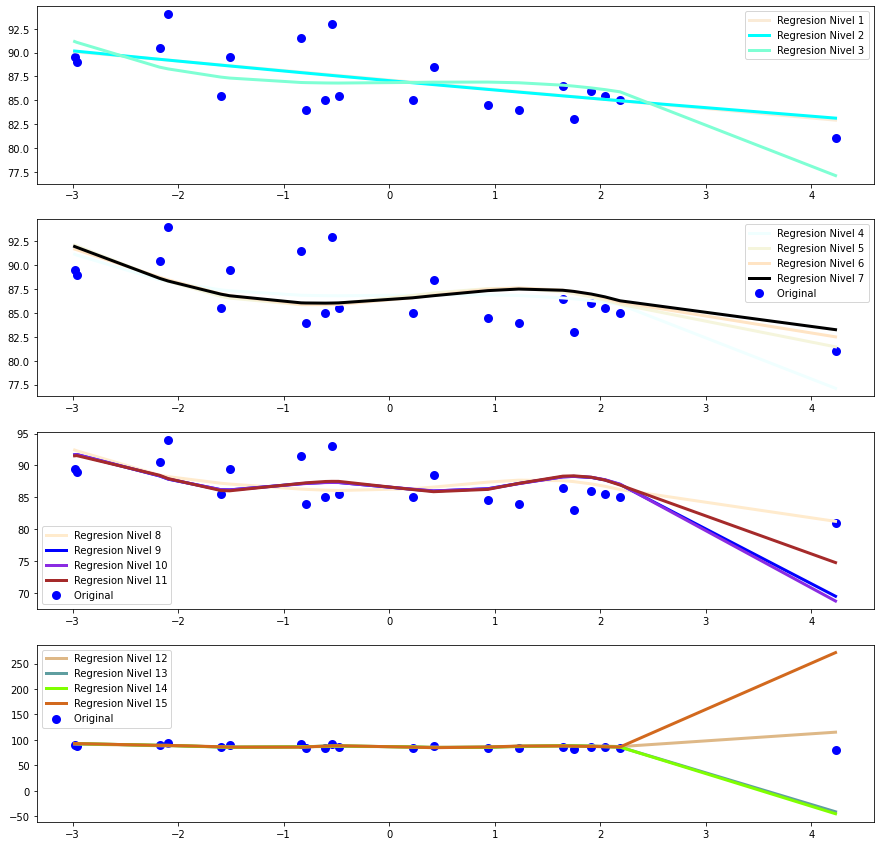

In [171]:
#Regresion Polinomica con un solo componente de PCA, sabemos que tiene muy poca de la varianza del dataset(cerca del 34 porciento), pero quieramos probarlo de todos modos

colores=list(mcolors.CSS4_COLORS.keys())
regresiones=[]
cantidadDeRegresionesFrom=1
cantidadDeRegresionesTo=16
grafs=int(cantidadDeRegresionesTo**0.5)

#fig,axs=plt.plot(range(len(y_train)),y_train)
figure, axis = plt.subplots(grafs,figsize=(15, 15))
minError=999999999999999
minErrorRegresion=9999
errores=[]

pca1C=pcaArray[0]
myCurrentXVectorTrain=np.array(pca1C.transform(X_train_scaled)).flatten()
myCurrentXVectorTest=np.array(pca1C.transform(X_test_scaled)).flatten()

order=np.argsort(myCurrentXVectorTrain)
myCurrentXVectorTrainOrdered=myCurrentXVectorTrain[order]

y_train_ordered=y_train[order]

order=np.argsort(myCurrentXVectorTest)
myCurrentXVectorTestOrdered=myCurrentXVectorTest[order]
y_test_ordered=y_test[order]

print("nivel de regresion","\t","errorTrain","\t\t","errorTest")
for regresion in range(cantidadDeRegresionesFrom,cantidadDeRegresionesTo):
  regresiones.append(np.polyfit(myCurrentXVectorTrainOrdered,y_train_ordered,regresion))
  yhat=np.polyval(regresiones[regresion-1],myCurrentXVectorTestOrdered)
  #Grafico la regresion
  axis[regresion//grafs].plot(myCurrentXVectorTestOrdered, yhat, linewidth=3.0,color=colores[regresion],label='Regresion Nivel '+str(regresion))
  #Grafico la f original en cada subplot
  axis[regresion//grafs].legend()
  #Calculo el error de esta regresion (Uso error cuadratico medio)
  yhattrain=np.polyval(regresiones[regresion-1],myCurrentXVectorTrainOrdered)
  errorTrain=np.sum((yhattrain-y_train_ordered)**2)/len(y_train_ordered)

  errorTest=    np.sum(np.abs(yhat-y_test_ordered)**2)/len(yhat)
  print(regresion,"\t\t\t ",errorTrain,"\t ",errorTest)
  
  #Busco el de menor error
  errores.append(errorTest)
  if(regresion%grafs==0 or regresion==grafs-1):
    axis[regresion//grafs].scatter(myCurrentXVectorTestOrdered, y_test_ordered, linewidth=3.0,color="blue",label='Original ')
  if(regresion==cantidadDeRegresionesFrom or errorTest<minError):
    minError=errorTest
    minErrorRegresion=regresion
print("El mejor estimador es el de nivel",minErrorRegresion,"con un MSE de",minError)

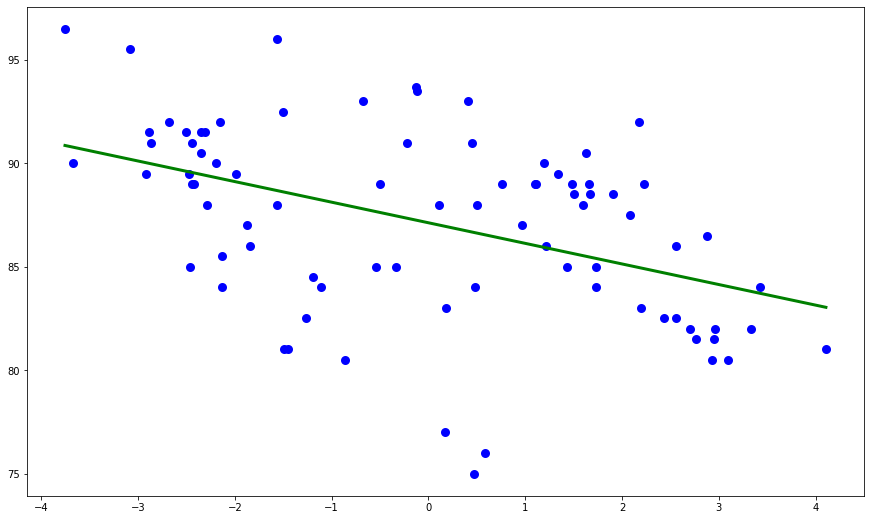

In [172]:
#Graficamos el mejor estimador
fig, axs = plt.subplots(1,sharey=True, figsize=(15, 9))
order=np.argsort(myCurrentXVectorTrain)

myCurrentXVectorTrainOrdered=myCurrentXVectorTrain[order]
y_train_ordered=y_train[order]

axs.scatter(myCurrentXVectorTrainOrdered, y_train_ordered, linewidth=3.0,color="blue",label='X_Test ')
axs.plot(myCurrentXVectorTrainOrdered, np.polyval(regresiones[minErrorRegresion-1],myCurrentXVectorTrainOrdered), linewidth=3.0,color="green",label='X_Test ')


Llegamos a la conclusión que el polinomio de grado 1 utilizando como predictor la primer componente de PCA del dataset escalado es la que obtuvo el mejor desempeño sobre el conjunto de test.

## Regresión empleando todos los predictores originales, pero con regularización ridge y lasso

In [173]:
print("Resultados Ridge con cross validation")
cva = RepeatedKFold(n_splits=10,n_repeats = 3, random_state=42)
model = RidgeCV(alphas=np.arange(0.5,10,0.1), cv=cva)
model.fit(X_train_scaled,y_train)
yhat=model.predict(X_test_scaled)
mse=sum((y_test-yhat)**2)/len(yhat)
coef_max = np.where(np.max(model.coef_))
cols_max = X.columns[coef_max]

print("Los coeficientes estimados con este modelo son",model.coef_)
print("El predictor que mayormente impacta sobre la variable objetivo es",cols_max.tolist())
print("MSE para X_train entero",sum((model.predict(X_test_scaled)-y_test)**2)/len(y_test),"con alpha igual a",model.alpha_)

#for i in range(0,10):
#  pca=pcaArray[i]
#  cva = RepeatedKFold(n_splits=10,n_repeats = 3, random_state=42)
#  model = RidgeCV(alphas=np.arange(0.5,10,0.1), cv=cva)
#  model.fit(pca.transform(X_train_scaled),y_train)
#  yhat=model.predict(pca.transform(X_test_scaled))
#  mse=sum((y_test-yhat)**2)/len(yhat)
#  print("MSE para",i+1,"componente/s es",mse,"con alpha igual a",model.alpha_)


Resultados Ridge con cross validation
Los coeficientes estimados con este modelo son [-0.79113626  0.4566318  -0.42864247  0.13802654  1.37576942  0.22407044
  2.18225801  0.9411389   0.12138366  0.09958718  0.44016083  0.16526256]
El predictor que mayormente impacta sobre la variable objetivo es ['site']
MSE para X_train entero 7.228485474343842 con alpha igual a 5.999999999999999


In [174]:
print("Resultados Lasso con cross validation")
cva = RepeatedKFold(n_splits=10,n_repeats = 3, random_state=42)
model = LassoCV(alphas=np.arange(0.001,1,.01), cv=cva,n_jobs=-1)
model.fit(X_train_scaled,y_train)
coef_max = np.where(np.max(model.coef_))
cols_max = X.columns[coef_max]
coef_cero = np.where(model.coef_==0)
cols_cero = X.columns[coef_cero]

print("Los coeficientes estimados con este modelo son",model.coef_,". Los predictores eliminados por lasso fueron",cols_cero.tolist())
print("El predictor que mayormente impacta sobre la variable objetivo es",cols_max.tolist())
print("MSE para X_train entero",sum((model.predict(X_test_scaled)-y_test)**2)/len(y_test),"con alpha igual a",model.alpha_)


#for i in range(0,10):
#  pca=pcaArray[i]
#  cva = RepeatedKFold(n_splits=10,n_repeats = 3, random_state=42)
#  model = LassoCV(alphas=np.arange(0.001,1,.01), cv=cva,n_jobs=-1)
#  model.fit(pca.transform(X_train_scaled),y_train)
#  yhat=model.predict(pca.transform(X_test_scaled))
#  mse=sum((y_test-yhat)**2)/len(yhat)
#  print("MSE para",i+1,"componente/s es",mse,"con alpha igual a",model.alpha_)


Resultados Lasso con cross validation
Los coeficientes estimados con este modelo son [-0.73366229  0.         -0.32666877  0.01590046  1.66080184  0.08191076
  2.3620997   0.69117129  0.          0.          0.40716779  0.05731031] . Los predictores eliminados por lasso fueron ['Pop', 'earconch', 'eye']
El predictor que mayormente impacta sobre la variable objetivo es ['site']
MSE para X_train entero 6.493941104962197 con alpha igual a 0.12099999999999998


En conclusión, la regresión PCR empleando una sola componente resultó útil para predecir la variable objetivo en términos del reducido error de test alcanzado en ese caso, a expensas de la pérdida de explicabilidad del modelo. En cambio, hacieno regresión sobre todo el data set original pero con regularización ridge y luego lasso, es posible conservar la propiedad de explicabilidad del modelo y, a la vez, obtener un error sobre el conjunto de test tambien reducido, comparable al mencionado al inicio del párrafo.